# Сборный проект - 1

Из открытых источников нам доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 
<br />**Цель исследования:** выявить определяющие успешность игры закономерности, чтобы в дальнейшем сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

plt.style.use('seaborn-whitegrid')

## Изучение исходных данных

In [3]:
try:
    df = pd.read_csv('games.csv')
except:
    df = pd.read_csv('/datasets/games.csv')

In [4]:
df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


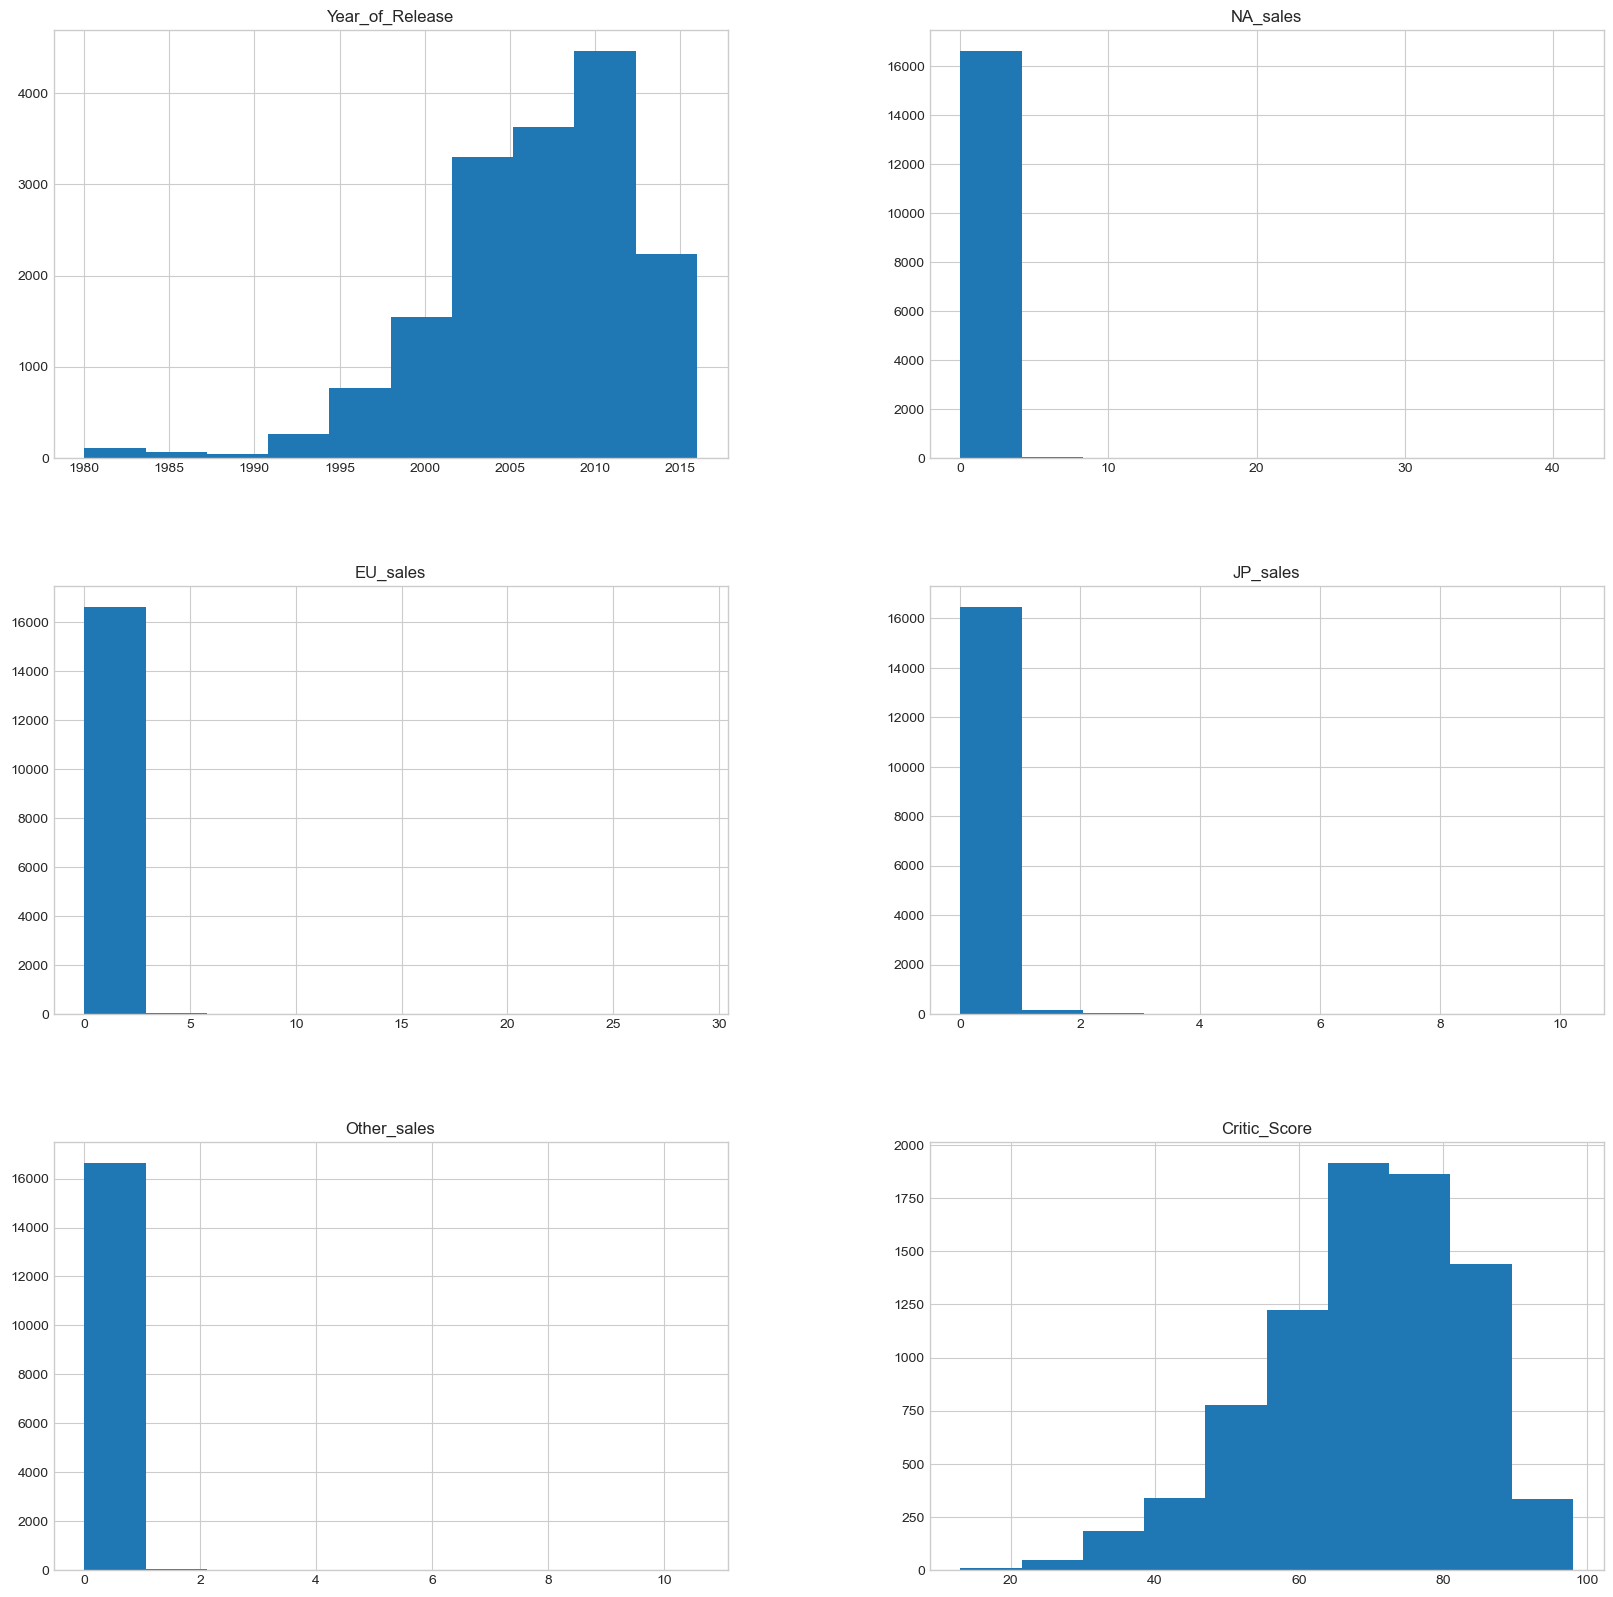

In [6]:
df.hist(figsize=(20, 20));

In [7]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


**Вывод**: Изучив исходные данные, можно предварительно сделать вывод, что в таблице присутствуют пропуски, причем более 50% в данных с оценками критиков, в жанных об оценках пользователей и в рейтинге пропуски составляют примерно 1/3 часть всей выборки. Более того, некоторые типы данных отображены некорректно и должны быть изменены. Проанализировав статистику, можно заметить, что в среднем продажи во всех регионах на одном уровне, но присутствуют и высокие значения, которые влияют на среднее значение. Значения оценки критиков, как видно распределены нормально.

## Подготовка данных

### Приведение названия столбцов к нижнему регистру

In [8]:
#Приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

### Преобразование типов данных

In [9]:
#Преобразуем типы данных:
    #в столбцах year_of_release и critic_score на целочисленный формат, т.к. год является целочисленным значением
df['year_of_release'] = df['year_of_release'].astype('Int32')
    #заменим тип данных float64 на float32 для экономии памяти
df[df.select_dtypes(include=['float64']).columns] = df[df.select_dtypes(include=['float64']).columns].astype('float32')

### Работа с пропусками

In [10]:
#Проверим, есть ли дубликаты
df.duplicated().unique()

array([False])

In [11]:
#Найдем столбцы с пропусками
df.isna().any()[df.isna().any() == True].index

Index(['name', 'year_of_release', 'genre', 'critic_score', 'user_score',
       'rating'],
      dtype='object')

#### Пропуски в столбце 'name'

In [12]:
#В столбце name всего 2 записи имеют пропуск, что составляет 0.01% от всей выборки. 
#Удаление данных строк не приведет к искажению данных.
df.dropna(subset=['name'], inplace=True)

#### Пропуски в столбце 'year_of_release'

In [13]:
#Изучим пропуски в столбце year_of_release
df[df['year_of_release'].isna()].shape[0]

269

In [14]:
#Так как игра может выпускаться на разных платформах в разные годы, то в виду отсутствия информации удалим имеющиеся пропуски
#(1.6% от всей выборки).
df.dropna(subset=['year_of_release'], inplace=True)

#### Пропуски в столбце 'genre'

In [15]:
df[df['genre'].isna()].shape[0]

0

Видим, что пропуски в данном столбце были удалены в процессе работы с пропусками в предыдущих столбцах.

#### Пропуски в столбцах 'critic_score',  'rating'

In [16]:
df['critic_score'].isna().sum()

8461

In [17]:
df['rating'].isna().sum()

6676

In [18]:
#Т.к. рейтинг это категориальный признак, заполним пропуски значением unknown.
df['rating'] = df['rating'].fillna('unknown')

In [19]:
df['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

#### Пропуски в столбце 'user_score'

In [20]:
df['user_score'].isna().sum()

6605

In [21]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [22]:
#Видим, что в данном столбце кроме числовых и nan значений есть значение tbd (to be determined), что означает подлежит уточнению.
#Таким образом, в виду отсутствия данных, заменим эти значения на nan и изменим тип данных столбца.
df['user_score'] = df['user_score'].replace('tbd', np.nan).astype('float32')

In [23]:
df['user_score'].isna().sum()

8981

#### Суммарные продажи

In [24]:
df['total_sales'] = df['na_sales']+df['eu_sales']+df['jp_sales']+df['other_sales']
df.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.360001,28.959999,3.77,8.45,76.0,8.0,E,82.539993
1,Super Mario Bros.,NES,1985,Platform,29.080000,3.580000,6.81,0.77,NaN,NaN,unknown,40.240002
2,Mario Kart Wii,Wii,2008,Racing,15.680000,12.760000,3.79,3.29,82.0,8.3,E,35.520000
3,Wii Sports Resort,Wii,2009,Sports,15.610000,10.930000,3.28,2.95,80.0,8.0,E,32.770000
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.270000,8.890000,10.22,1.00,NaN,NaN,unknown,31.380001


**Вывод**: В результате подготовки исходных данных изменили названия столбцов, привели их в общий вид, изменили типы данных (год выпуска - в целочисленный формат, остальные числовые значения в float32), убедились в отсутствии дубликатов. В столбцах жанр игры, имя и рейтинг поработали с пропусками. В частности в столбце рейтинг заменили пропуски заглушкой, чтобы в дальнейшем можно было провести более полный анализ. Пропуски в столбце год выпуска удалили, т.к. нельзя их корректно заполнить и они составляют всего 1.6% от исходных данных. Пропуски в столбцах с оценками критиков и пользователей оставили нетронутыми, так как пропуски составляют более 50% всех данных и их изменение может повлиять на конечный результат. Причинами наличия пропусков могут быть ошибки при переносе данных, отсутствие этих самых данных изначально и т.д.

## Исследовательский анализ данных

**Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?**

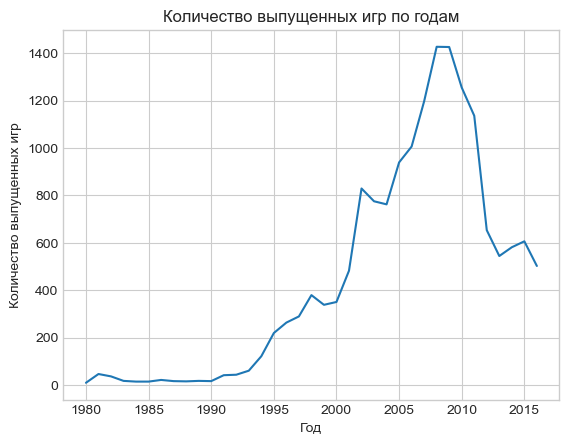

In [25]:
released_per_year = df.groupby('year_of_release')['name'].count()
sns.lineplot(data=released_per_year)
plt.title('Количество выпущенных игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество выпущенных игр');

**Вывод**:Видим, что, начиная с 1990 года по 2007 год количество выпущенных компьютерных игр растет, что связано с развитием и распространением ПК. Спад после 2007 года характеризует внедрение мобильных телефонов и развитие игровой отрасли на данных мобильных платформах. Так как, активный рост начинается с 2000 годов, то оставим данные, начиная с этого времени.

In [26]:
df = df[df['year_of_release']>=2000]

**Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?**

In [27]:
top10_sales_per_platform = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10)
print('\033[1m Топ-10 платформ с наибольшими суммарными продажами \033[0m', top10_sales_per_platform)

 Топ-10 платформ с наибольшими суммарными продажами  platform
PS2     1233.559937
X360     961.239990
PS3      931.339966
Wii      891.179993
DS       802.760010
PS4      314.140015
GBA      312.880005
PSP      289.529999
3DS      257.809998
XB       251.569992
Name: total_sales, dtype: float32


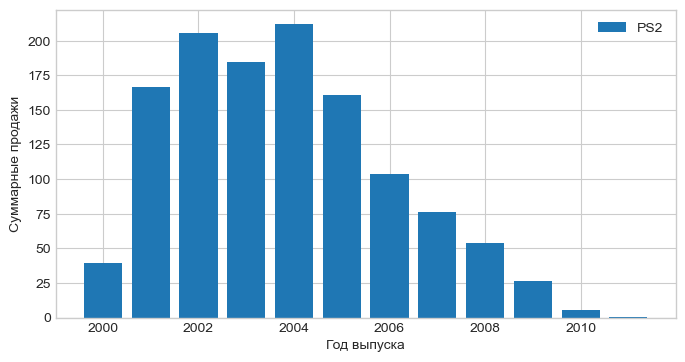

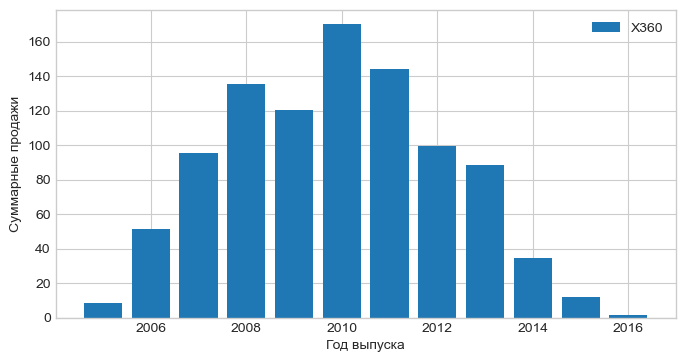

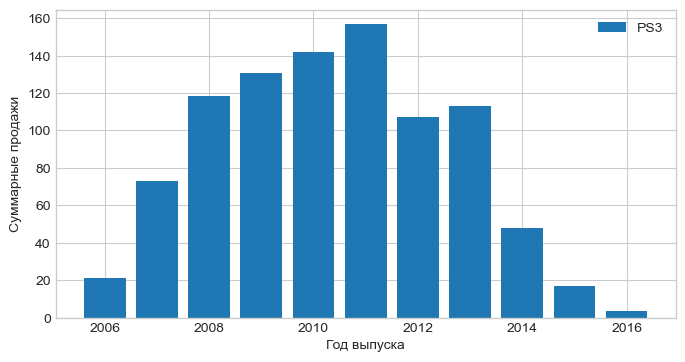

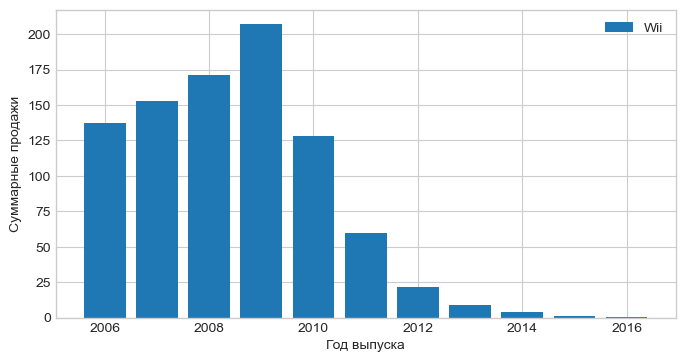

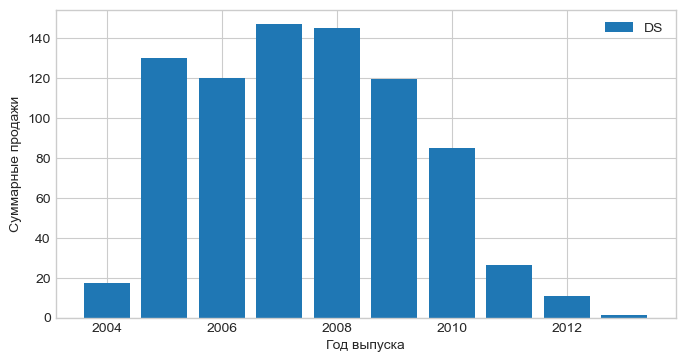

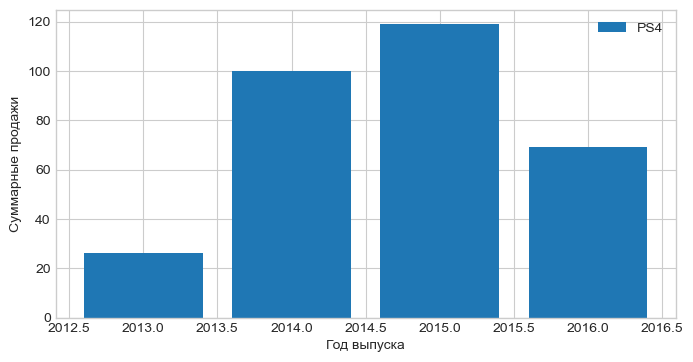

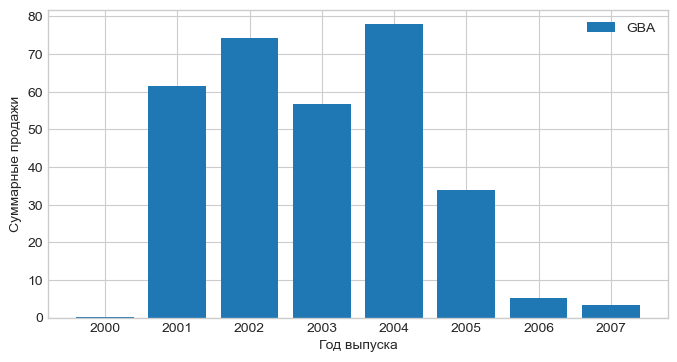

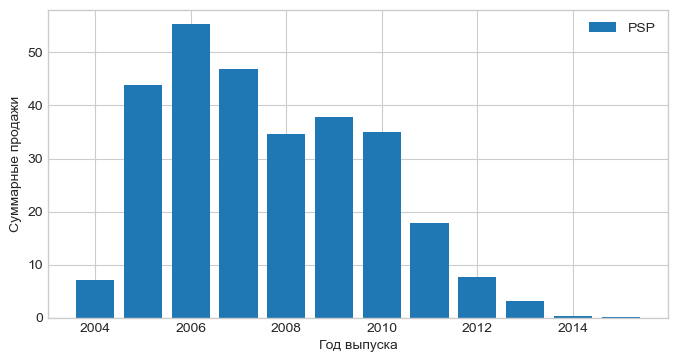

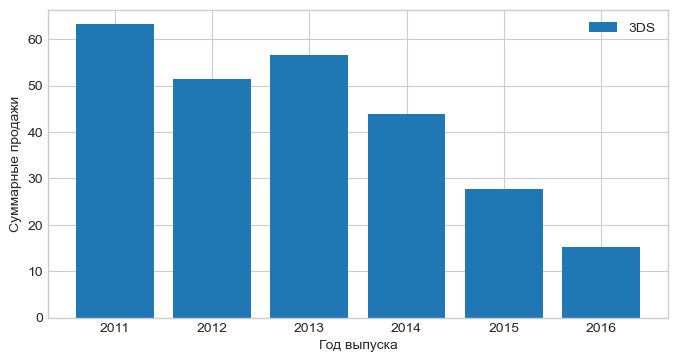

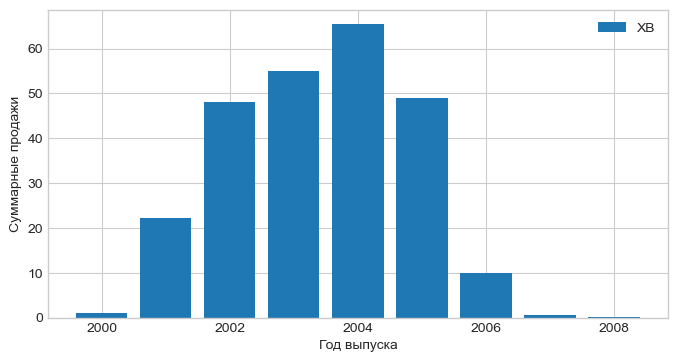

In [28]:
for i in list(top10_sales_per_platform.index):
    platform = df[df['platform']==i].groupby('year_of_release')['total_sales'].sum()
    fig, ax = plt.subplots(figsize=(8,4))
    plt.bar(platform.index,platform.values, label=i)
    plt.ylabel('Суммарные продажи')
    plt.xlabel('Год выпуска')
    plt.legend()
    plt.show()

**Вывод**: Отталкиваясь от построенных распределений,можно сделать вывод, что в среднем цикл с момента появления платформы и до момента ее исчезновения составляет около 10 лет. Более того, можно заметить, что из топ-10 платформ, платформы, на которых все еще выпускались игры в 2016 году, появлись в 2006 году. Появившиеся до этого времени платформы к 2016 не давали никакую прибыль, т.е. на них игры не выпускались (например PS2, DS, GBA, XB). Более того, видно, что пик продаж на платформах проходит за 4 года Поэтому за актуальный период приму `2012-2016` года. 

In [29]:
df = df[df['year_of_release']>=2012]

**Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.**

In [30]:
top_5_platforms = df[df['year_of_release'] == 2016].groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(5)
top_5_platforms

platform
PS4     69.25
XOne    26.15
3DS     15.14
PC       5.25
WiiU     4.60
Name: total_sales, dtype: float32

**Вывод**: Видим, что на конец актуального периода лидируют по продажам следующие платформы: `PS4, XOne, 3DS, PC, WiiU`.

**Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.**

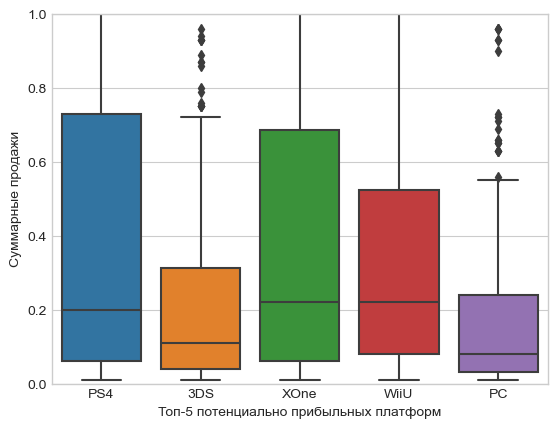

In [31]:
top_5_platforms_df = df[df['platform'].isin(list(top_5_platforms.index))]
sns.boxplot(data=top_5_platforms_df, x='platform', y='total_sales' )
plt.ylim(0,1)
plt.ylabel('Суммарные продажи')
plt.xlabel('Топ-5 потенциально прибыльных платформ');

In [32]:
top_5_platforms_df.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,396.0,0.491439,1.387163,0.01,0.04,0.11,0.3125,14.599999
PC,250.0,0.250600,0.494641,0.01,0.03,0.08,0.2400,5.140000
PS4,392.0,0.801377,1.609457,0.01,0.06,0.20,0.7300,14.630000
WiiU,147.0,0.559115,1.058836,0.01,0.08,0.22,0.5250,7.090000
XOne,247.0,0.645020,1.036139,0.01,0.06,0.22,0.6850,7.390000


**Вывод**: Во первых, из графика видно, что есть большое количество выбросов, это означает, что некоторые релизы были очень успешными. Во-вторых, анализируя средние и медианные значения глобальных продаж, можно отметить, что в среднем высокие продажи обеспечивают такие платформы как `PS4, XOne, WiiU`, это можно объяснить тем, что данные платформы новые и стоимость игр на них достаточно высока. Таким образом, вышеупомянутые 3 платформы являются наиболее прибыльными.

**Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.**

(0.0, 10.0)

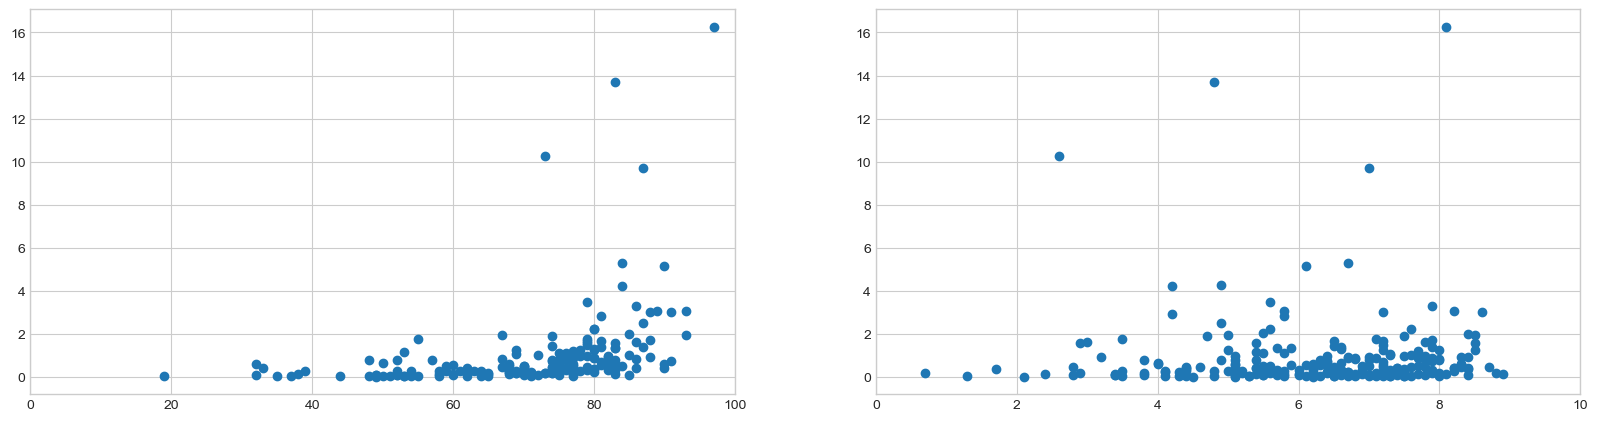

In [52]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax1.scatter(x=df[(df['platform']=='X360')&(df['year_of_release'] >=2012)]['critic_score'], y=df[(df['platform']=='X360')&(df['year_of_release'] >=2012)]['total_sales'])
ax2.scatter(x=df[(df['platform']=='X360')&(df['year_of_release'] >=2012)]['user_score'], y=df[(df['platform']=='X360')&(df['year_of_release'] >=2012)]['total_sales'])
ax1.set_xlim([0,100])
ax2.set_xlim([0,10])

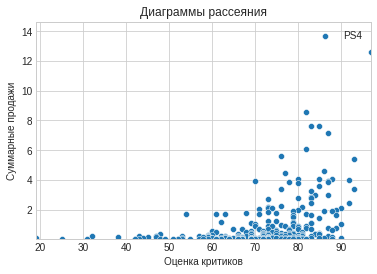

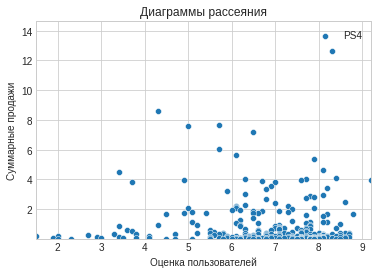

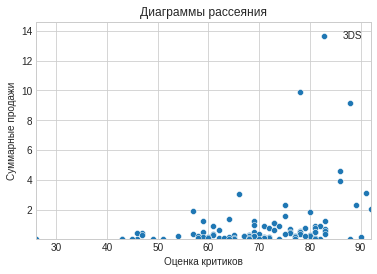

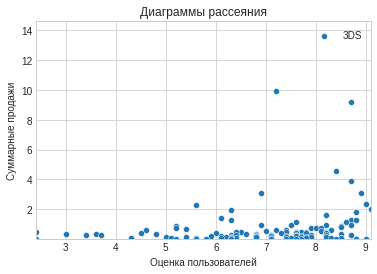

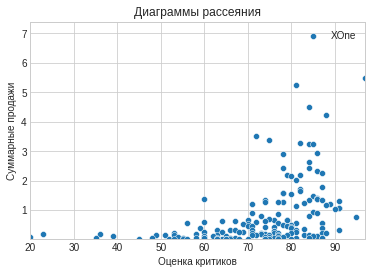

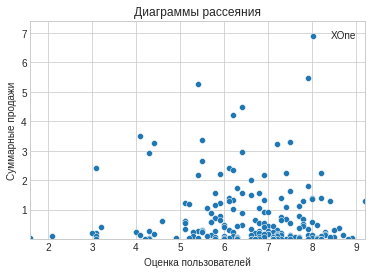

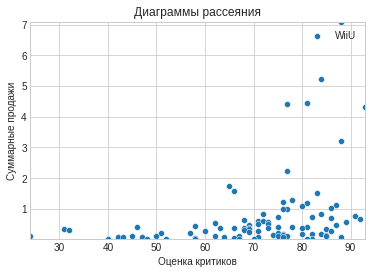

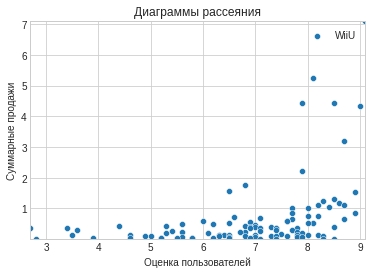

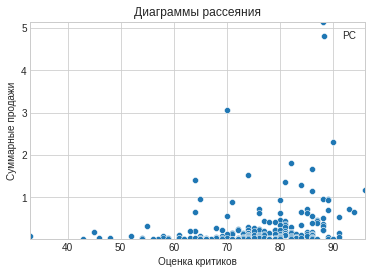

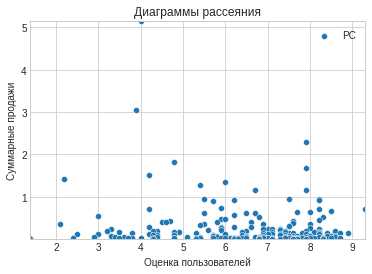

In [32]:
# Рассмотрим 5 наиболее популярных платформ
for k in list(top_5_platforms_df['platform'].unique()):
    pl_df = top_5_platforms_df[top_5_platforms_df.platform == k]
    for i in ['critic_score', 'user_score']:
        dict1 = {'critic_score':'Оценка критиков','user_score' :'Оценка пользователей'}
        sns.scatterplot(data=pl_df, x=i, y='total_sales',label=k);
        plt.title('Диаграммы рассеяния')
        plt.ylabel('Суммарные продажи')
        plt.xlabel(dict1[i])
        plt.ylim(pl_df['total_sales'].min(),pl_df['total_sales'].max())
        plt.xlim(pl_df[i].min(),pl_df[i].max())
        plt.show()

In [33]:
for k in list(top_5_platforms_df['platform'].unique()):
    print(f'\033[1m {k}\033[0m', top_5_platforms_df[top_5_platforms_df['platform'] == k][['total_sales', 'critic_score', 'user_score']].corr(), '\n')

 PS4               total_sales  critic_score  user_score
total_sales      1.000000      0.406568   -0.031957
critic_score     0.406568      1.000000    0.557654
user_score      -0.031957      0.557654    1.000000 

 3DS               total_sales  critic_score  user_score
total_sales      1.000000      0.320803    0.197583
critic_score     0.320803      1.000000    0.722762
user_score       0.197583      0.722762    1.000000 

 XOne               total_sales  critic_score  user_score
total_sales      1.000000      0.416998   -0.068925
critic_score     0.416998      1.000000    0.472462
user_score      -0.068925      0.472462    1.000000 

 WiiU               total_sales  critic_score  user_score
total_sales      1.000000       0.34838    0.400219
critic_score     0.348380       1.00000    0.770080
user_score       0.400219       0.77008    1.000000 

 PC               total_sales  critic_score  user_score
total_sales      1.000000      0.237243   -0.121867
critic_score     0.237243     

**Вывод**: Из построенных графиков видна прямая пропорциональная зависимость между суммарными продажами и оценкой критиков. Т.е. чем выше оценка критиков, тем выше продажи. Получается, что мнение критиков играет ключевую роль при покупке пользователем игры. Зависимость между оценкой пользователей и продажами в большинстве случаев слабая либо ее нет, исключением является лишь платформа WiiU. Данный феномен затрудняюсь объяснить.

**Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?**

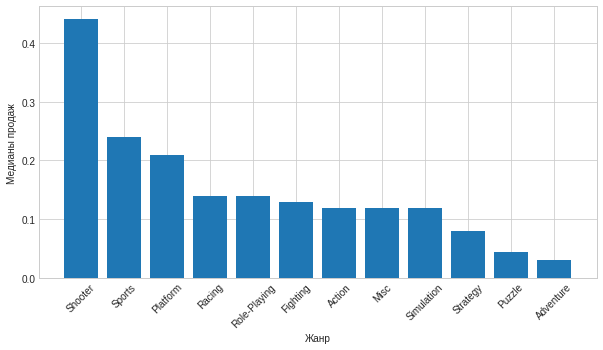

In [34]:
genre_sales = df.groupby('genre')['total_sales'].median().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(x=genre_sales.index, height=genre_sales.values)
plt.xticks(rotation=45)
plt.ylabel('Медианы продаж')
plt.xlabel('Жанр');

**Вывод**: Наиболее прибыльными являются игры в жанрах `Shooter, Sports, Platform`, наименне прибыльными являются жанры `Puzzle, Adventure`. Анализ прибыльности жанра проводил по медианам продаж, чтобы избежать влияния выбросов. Причинами популярности одних жанров и неопопулярности других могут быть разные факторы, такие как интерес сюжета, его динамичность, способность вызвать эмоции и т.д. 

## Портрет пользователя каждого региона

Топ платформ по продажам в разных регионах


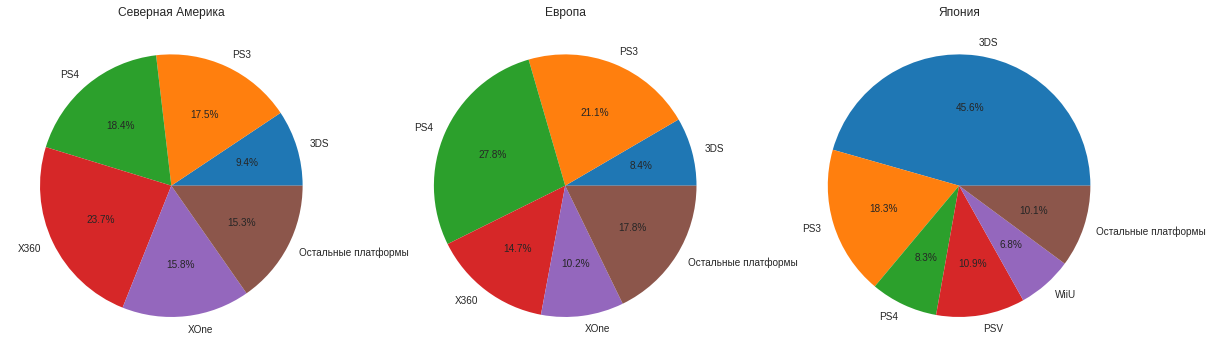

In [35]:
fig, ax = plt.subplots(figsize=(20,10), nrows=1, ncols=3)
dict2 = {'na_sales':'Северная Америка','eu_sales' :'Европа','jp_sales': 'Япония'}
print('\033[1mТоп платформ по продажам в разных регионах')
for i, region in enumerate(['na_sales','eu_sales', 'jp_sales' ]):
    df_draw = df.copy()
    other_platforms = list(df_draw.groupby("platform")[region].sum().sort_values(ascending=False).iloc[5:].index)
    df_draw['platform'].replace(other_platforms, 'Остальные платформы', inplace=True)
    ax[i].pie(df_draw.groupby("platform")[region].sum(), labels=df_draw.groupby("platform")[region].sum().index, autopct='%1.1f%%')
    ax[i].set_title(dict2[region])

Топ жанров по продажам в разных регионах


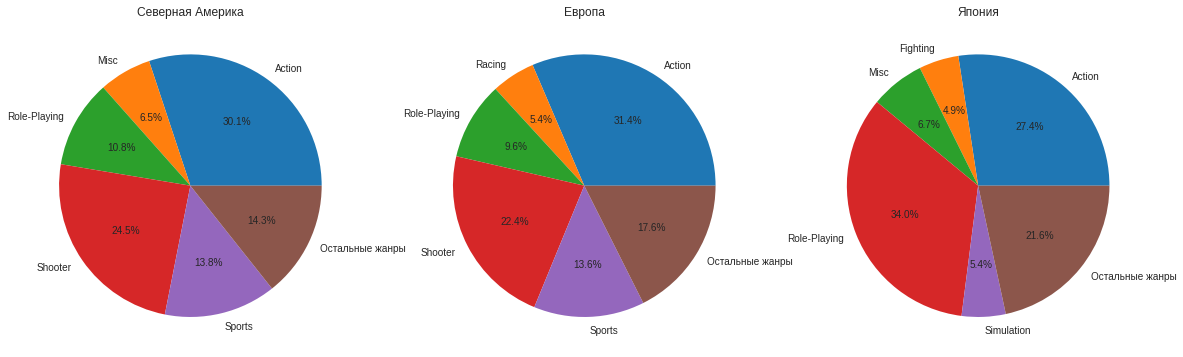

In [36]:
fig, ax = plt.subplots(figsize=(20,10), nrows=1, ncols=3)
dict2 = {'na_sales':'Северная Америка','eu_sales' :'Европа','jp_sales': 'Япония'}
print('\033[1mТоп жанров по продажам в разных регионах')
for i, region in enumerate(['na_sales','eu_sales', 'jp_sales' ]):
    df_draw = df.copy()
    other_platforms = list(df_draw.groupby("genre")[region].sum().sort_values(ascending=False).iloc[5:].index)
    df_draw['genre'].replace(other_platforms, 'Остальные жанры', inplace=True)
    ax[i].pie(df_draw.groupby("genre")[region].sum(), labels=df_draw.groupby("genre")[region].sum().index, autopct='%1.1f%%')
    ax[i].set_title(dict2[region])

Топ рейтинга по продажам в разных регионах


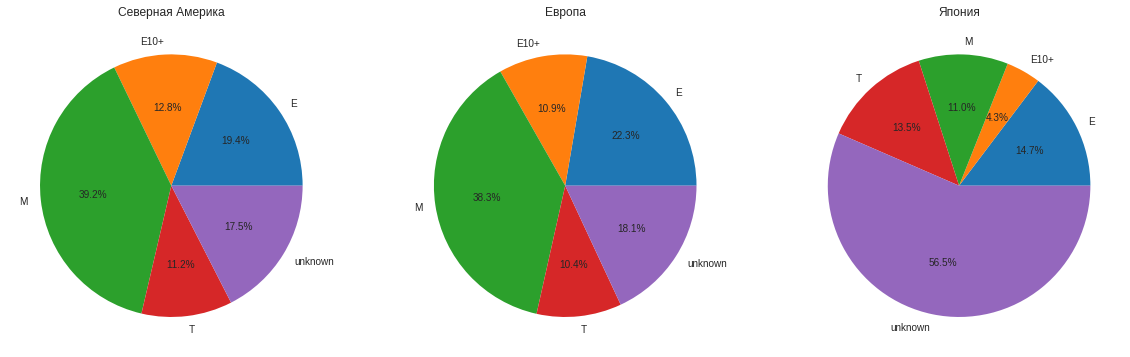

In [37]:
fig, ax = plt.subplots(figsize=(20,10), nrows=1, ncols=3)
dict2 = {'na_sales':'Северная Америка','eu_sales' :'Европа','jp_sales': 'Япония'}
print('\033[1mТоп рейтинга по продажам в разных регионах')
for i, region in enumerate(['na_sales','eu_sales', 'jp_sales' ]):
    ax[i].pie(df.groupby("rating")[region].sum(), labels=df.groupby("rating")[region].sum().index, autopct='%1.1f%%')
    ax[i].set_title(dict2[region])

**Вывод**: 
* Популярные платформы в регионах разные: в Северной Америке - X360, в Европе - PS3, в Японии - 3DS.
* В Северной Америке и Европе 4 из 5 популярных жанров совпадают. Лидирующими по продажам являются игры жанра Action. В Японии наиболее прибыльные игры жанра Role-Playing, более того в топе присутствуют жанры, которых нет в других регионах. Разница может быть обусловлена культурными особенностями и интересами граждан данного региона.
* Касаемо рейтинга ESRB в Северной Америке и Европе распределение практически одинаково, наиболее популярными являются игры с рейтинго М (для взрослых), касаемо рейтингов в Японии, то у более 50% данных отсутсвует рейтинг, а из имеющихся данных наиболее прибыльные игры с рейтингом E (для всех).

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

`Нулевая гипотеза:` Средние пользовательские рейтинги платформ Xbox One и PC равны.
<br />`Альтернативная гипотеза:` Средние пользовательские рейтинги платформ Xbox One и PC не равны.

In [38]:
sample_1 = df[df['platform'] == 'XOne']['user_score'].dropna()
sample_2 = df[df['platform'] == 'PC']['user_score'].dropna()

print('Размер выборки 1:',len(sample_1))
print('Размер выборки 2:',len(sample_2))

Размер выборки 1: 182
Размер выборки 2: 206


In [39]:
#Т.к. размеры выборок разные, то будем считать, что дисперсии у генеральных совокупностей разные 
results = st.ttest_ind(sample_1, sample_2, equal_var=False)

#alpha = .01
alpha = .05

print(f'p-значение', results.pvalue)

if results.pvalue < alpha :
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение 0.5489560463017016
Не получилось отвергнуть нулевую гипотезу


**Вывод**: При проверке данной гипотезы дисперсии считались разными из-за разного размера выборок. Пороговое значение в данном случае не играло большую роль, т.к. при 1% и 5% нулевая гипотеза не отвергается. Таким образом, средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

### Средние пользовательские рейтинги жанров Action и Sports разные.

`Нулевая гипотеза:`  Средние пользовательские рейтинги жанров Action и Sports равны.
<br />`Альтернативная гипотеза:`  Средние пользовательские рейтинги жанров Action и Sports не равны.

In [40]:
sample_1 = df[df['genre'] == 'Action']['user_score'].dropna()
sample_2 = df[df['genre'] == 'Sports']['user_score'].dropna()

print('Размер выборки 1:',len(sample_1))
print('Размер выборки 2:',len(sample_2))

Размер выборки 1: 523
Размер выборки 2: 195


In [41]:
#Т.к. размеры выборок разные, то будем считать, что дисперсии у генеральных совокупностей разные 
results = st.ttest_ind(sample_1, sample_2, equal_var=False)

#alpha = .01
alpha = .05

print(f'p-значение', results.pvalue)

if results.pvalue < alpha :
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение 4.242899260229549e-20
Отвергаем нулевую гипотезу


**Вывод**: При проверке данной гипотезы дисперсии так же считались разными из-за разного размера выборок. Пороговое значение в данном случае не играло большую роль, т.к. при 1% и 5% нулевая гипотеза отвергалась. Таким образом, гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports разные подтвердилась.

## Общий вывод

1. В результате проделанной работы, мною была произведена предобработка исходных данных: привел названия столбцов к общему виду, изменил типы данных в столбцах на правильные, учитывая экономию памяти, обработал пропуски. В результате работы с пропусками, некоторые записи были удалены ( 0.8% от всей выборки). В 3-х столбцах (оценка пользователей и критиков) было решено оставить пропуски ввиду их большого количества, чтобы не исказить исходные данные. В рейтинге пропуски были замененые на значение 'unknown'. Заменил значение tbd на NaN, т.к. оно подразумевало, что данных на момент заполнения датасета нет. Так же мной было посчитано общее количество продаж по всем регионам и записано в новый столбец total_sales.
2. В результате ИАД было определено, что количество выпускаемых игр на различные платформы начало резко расти с 2000 - х годов. Было определено, что платформа в среднем около 10 лет пользуется популярностью и используется для релиза игр, далее на смену приходят новые платформы. Я определил, что в среднем высокие продажи обеспечивают такие платформы как `PS4, XOne, WiiU`, являющиеся потенциально прибыльными. Выявлено, что чем выше оценка критиков, тем выше продажи. Получается, что мнение критиков играет ключевую роль при покупке пользователем игры. Яркая зависимость между пользовательской оценкой и продажами не обнаружена. Наиболее прибыльными являются игры в жанрах `Shooter, Sports, Platform`, а наименне прибыльными являются жанры `Puzzle, Adventure`.
3. Далее был составлен портрет пользователя каждого региона: в Северной Америке пользуется популярностью `X360`, в Европе - `PS3`, в Японии -`3DS`. Вкусы пользователей в Европе и Северной Америке совпадают, наиболее популярными жанрами игр в данных регионах являются `Action, Sports, Shooter, Misc, Role-Playing и Racing` . В Японии наиболее прибыльные игры жанра `Role-Playing, Action, Misc, Simulation, Fighting`. Касаемо рейтинга ESRB в Северной Америке и Европе распределение практически одинаково, наиболее популярными являются игры с рейтинго М (для взрослых), касаемо рейтингов в Японии, то у более 50% данных отсутсвует рейтинг, а из имеющихся данных наиболее прибыльные игры с рейтингом E (для всех).
4. Последним шагом в проекте была проверка гипотез, было получено:
* Средние пользовательские рейтинги платформ Xbox One и PC **одинаковые**.
* Средние пользовательские рейтинги жанров Action и Sports **разные**.